In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import hyperdash as hd

%load_ext autoreload

In [ ]:
#'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster', 'item_nbr', 'n_family', 'class', 'perishable'

In [2]:
unit_mean, unit_std = pd.read_csv('data/mean_std.csv', index_col=0).T[0]

In [3]:
df_stores = pd.read_csv(
    'data/num_stores.csv.gz',
     dtype={
         'store_nbr': np.uint8,
         'n_city': np.uint8,
         'n_state': np.uint8,
         'n_type': np.uint8,
         'cluster': np.uint8
     }

)
df_items = pd.read_csv(
    'data/num_items.csv.gz',
    dtype={
        'item_nbr': np.int32,
        'n_family': np.uint8,
        'class': np.int16,
        'perishable': np.int8,
    }
)
for stores_col in ['n_city', 'n_state', 'n_type', 'cluster']:
    df_stores[stores_col] = df_stores[stores_col] - df_stores[stores_col].min()
    
for items_col in ['n_family', 'class', 'perishable']:
    df_items[items_col] = df_items[items_col] - df_items[items_col].min()

In [4]:
%%time
df = pd.read_csv(
    'data/ts.csv.gz',
    parse_dates=[0],
    #nrows=1000000,
    dtype={
        'item_nbr': np.int32,
        'store_nbr': np.int8,
        'unit_sales': np.float32,
        'onpromotion': np.int8,
        'holiday': np.int8,
        'weekend': np.int8,
        'waged_day': np.int8,
        'dow_0': np.int8,
        'dow_1': np.int8,
        'dow_2': np.int8,
        'dow_3': np.int8,
        'dow_4': np.int8,
        'dow_5': np.int8,
        'dow_6': np.int8,
    }
)
df.head()

CPU times: user 5min 55s, sys: 10.8 s, total: 6min 6s
Wall time: 5min 30s


In [5]:
%%time
ts_columns = df.columns[3:]
      
attr_cols = [
    'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster',
    'item_nbr', 'n_family', 'class',
    #'perishable'
]

df_pivot = df.pivot_table(
    index=['store_nbr', 'item_nbr'],
    columns=['date'],
    values=ts_columns
).reset_index()

df_pivot = df_pivot.merge(df_items, on='item_nbr')
df_pivot['store_nbr'] = df_pivot[('store_nbr', '')]
df_pivot = df_pivot.merge(df_stores, on='store_nbr')

/home/dmitry/miniconda3/envs/tf_intel/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


CPU times: user 13min 24s, sys: 2min 27s, total: 15min 52s
Wall time: 12min 42s


In [6]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210654 entries, 0 to 210653
Columns: 9887 entries, item_nbr to cluster
dtypes: float64(823), int16(1), int64(4), int8(9054), uint8(5)
memory usage: 3.1 GB


In [55]:
def get_date_cols(date, history=20, predict_days=16, ts_columns=ts_columns, skip=0):
                  #date, days=1, attr_cols=attr_columns_wo_means, ts_cols=ts_columns, attr=True):
    
    if type(date) != pd.Timestamp:
        date = pd.to_datetime(date)
        
    X_start_date = date - pd.Timedelta('{} days'.format(history-1))
    #X_end_date = date
    y_start_date = date + pd.Timedelta('{} days'.format(skip+1))
    #y_end_date = date + pd.Timedelta('{} days'.format(predict_days))

    X_cols, y_cols, y_day_attr_cols = [], [], []
    
    for d in pd.date_range(X_start_date, periods=history, freq='D'):
        for elem in ts_columns:
            X_cols.append((elem, d))
            
    for d in pd.date_range(y_start_date, periods=predict_days, freq='D'):
        y_cols.append(('unit_sales_scaled', d))
        for elem in ts_columns[1:]:
            y_day_attr_cols.append((elem, d))
            
    return X_cols, y_cols, y_day_attr_cols



X_cols, y_cols, y_day_attr_cols = get_date_cols('2017-08-15', predict_days=5)
    
df_pivot.head().loc[:, y_day_attr_cols]

,"(onpromotion, 2017-08-16 00:00:00)","(holiday, 2017-08-16 00:00:00)","(weekend, 2017-08-16 00:00:00)","(waged_day, 2017-08-16 00:00:00)","(dow_0, 2017-08-16 00:00:00)","(dow_1, 2017-08-16 00:00:00)","(dow_2, 2017-08-16 00:00:00)","(dow_3, 2017-08-16 00:00:00)","(dow_4, 2017-08-16 00:00:00)","(dow_5, 2017-08-16 00:00:00)",...,"(holiday, 2017-08-20 00:00:00)","(weekend, 2017-08-20 00:00:00)","(waged_day, 2017-08-20 00:00:00)","(dow_0, 2017-08-20 00:00:00)","(dow_1, 2017-08-20 00:00:00)","(dow_2, 2017-08-20 00:00:00)","(dow_3, 2017-08-20 00:00:00)","(dow_4, 2017-08-20 00:00:00)","(dow_5, 2017-08-20 00:00:00)","(dow_6, 2017-08-20 00:00:00)"
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [124]:
def get_random_train_test(df_pivot,
        date, window=21, freq=7, size=2000, history=1, predict_days=16, epochs=2, 
        shuffle_dates=True, shuffle_indexes=True, attr_cols=attr_cols, ts_columns=ts_columns, skip=skip):
    
    
    window = freq * (window//freq)
    num_items = df_pivot.shape[0]
    
    date = pd.to_datetime(date)
    start_window =  date - pd.Timedelta('{} days'.format(window))
    end_date = date
    
    dates = pd.date_range(start=start_window, end=end_date)
    dates = dates[::freq]
    
    print(dates)
    
    patches = []
    #end_X_date = end_date - pd.Timedelta('{} days'.format(label_dates))
    if shuffle_dates and shuffle_indexes:
        permutated_dates = np.random.permutation(dates)
        permutated_indx = np.random.permutation(num_items)   
        for epoch in range(epochs):
            for i in range(num_items//size+1):
                s = size * i
                e = size * (i+1)
                indexes = permutated_indx[s:e]

                for date in permutated_dates:
                    patches.append([indexes, date])

        patches = np.random.permutation(patches)
        
    elif not shuffle_dates and shuffle_indexes:
        permutated_indx = np.random.permutation(num_items)
        for date in dates:
            for epoch in range(epochs):
                for i in range(num_items//size+1):
                    s = size * i
                    e = size * (i+1)
                    indexes = permutated_indx[s:e]
                    patches.append([indexes, date])

    for indexes, date in patches:
        df_pivot_slice = df_pivot.iloc[indexes]
        X_cols, y_cols, y_day_attr_cols = get_date_cols(
            date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
        )

        X = np.array(
            df_pivot_slice.loc[:, X_cols]
        ).reshape([-1, history, len(ts_columns)])

        y_day_attr = np.array(
            df_pivot_slice.loc[:, y_day_attr_cols]
        ).reshape([-1, predict_days, len(ts_columns)-1])
        
        y = np.array(df_pivot_slice.loc[:, y_cols])
        features = [X, y_day_attr, y]
        for feature in attr_cols:
            features.append(
                np.array(df_pivot_slice.loc[:, feature])
            )
        for i in range(len(indexes)):
            yield tuple([elem[i] for elem in features])

tmp = get_random_train_test(df_pivot, '2017-07-15', window=20, history=90, predict_days=5)
tmp1 = next(tmp)
print(tmp1[0].shape, tmp1[1].shape, tmp1[2].shape, tmp1[3].shape)

DatetimeIndex(['2017-07-01', '2017-07-08', '2017-07-15'], dtype='datetime64[ns]', freq='7D')
(90, 12) (5, 11) (5,) ()


In [147]:
for i in range(2000):
    next(tmp)

In [148]:
next(tmp)

(array([[-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          1.        ,  0.        ]]), array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8), array([-0.71689729, -0.71689729, -0.71689729, -0.71689729, -0.71689729]), 36, 11, 6, 4, 9, 1960806, 30, 106)

In [57]:
def get_validation(df_pivot,
        date, history=1, predict_days=16, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    X_cols, y_cols, y_day_attr_cols = get_date_cols(
        date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
    )

    X = np.array(
        df_pivot.loc[:, X_cols]
    ).reshape([-1, history, len(ts_columns)])
    
    y_day_attr = np.array(
        df_pivot.loc[:, y_day_attr_cols]
    ).reshape([-1, predict_days, len(ts_columns)-1])

    y = np.array(df_pivot.loc[:, y_cols])
    features = [X, y_day_attr, y]
    for feature in attr_cols:
        features.append(
            np.array(df_pivot.loc[:, feature])
        )

    return features

tmp = get_validation(df_pivot, '2017-07-15', history=90, predict_days=5)
print(tmp[0].shape, tmp[1].shape, tmp[2].shape, tmp[3].shape)

(210654, 90, 12) (210654, 5, 11) (210654, 5) (210654,)


In [ ]:
%autoreload 2

history = 400
time_to_predict = 16
freq=1

last_day_train = '2017-07-14'
window=90
epochs = 100
validation_day = pd.to_datetime(last_day_train) + pd.Timedelta('{} days'.format(time_to_predict))
batch_size = 2000
sum_W = 3574368.0/16
skip=0

print(validation_day)

batch_gen = get_random_train_test(
    df_pivot,
    last_day_train,
    window=window,
    history=history,
    size=batch_size,
    predict_days=time_to_predict,
    epochs=epochs,
    skip=skip,
    freq=freq
)

val_set = get_validation(df_pivot, validation_day, history=history,
                        predict_days=time_to_predict, skip=skip)

from model import RNNModel

m = RNNModel(
    history=history,
    n_days_predict=time_to_predict,
    clip_gradients=5.,
    starter_learning_rate=0.0001,
    #starter_learning_rate=0.0005,
    n_layers_rnn=1,
    rnn_size_encoder=200,
    rnn_size_decoder=200,
)
print(1)
m.build_graph(batch_gen)


try:
    hd_exp.end()
except NameError:
    pass

hd_exp = hd.Experiment('RNN fav 3')

m.train(val_set, coef=unit_std, sum_W=sum_W,
        report_every=100, validate_every=1000,
        hd_exp=hd_exp)

2017-07-30 00:00:00
1
DatetimeIndex(['2017-04-15', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-04-28', '2017-04-29', '2017-04-30',
               '2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05',
               '2017-06-06', '2017-06-07', '2017-06-08'

In [31]:
sales = df[
    (df['item_nbr'] == 1503844) &
    (df['store_nbr'] == 44) 
    
]['unit_sales_scaled']

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

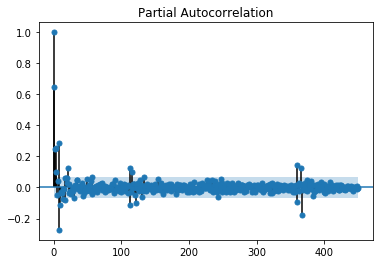

In [33]:
sm.graphics.tsa.plot_pacf(sales, lags=450)
plt.show()

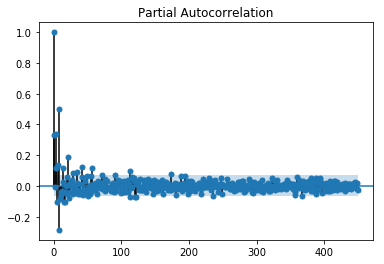

In [49]:
sales2, tmp = stats.boxcox((sales+unit_mean))
sm.graphics.tsa.plot_pacf(sales2, lags=450)
plt.show()